# Explaining some causes behind different project riks 
## Scenarios number 1

### What are the effects of different variables on average cyclomatic complexity? 
- Task: Effect estimation

In [2]:
# Imports
import pandas as pd
import numpy as np
import pygraphviz
import matplotlib.pyplot as plt
import dowhy
import networkx as nx
from dowhy import CausalModel
from dowhy import gcm

#### Initialization

In [3]:
data_path = "../data/useable/brave-browser/clean_tasks.csv"
dataset = pd.read_csv(data_path)

print(len(dataset))

# Display the first few rows of the filtered dataset
dataset.head()

1458


,task_type,has_bug_fixing,has_code_refactoring,loc,files_touched,author,committer,authored_at,commited_at,commit_time_in_day,...,communication,total_nloc,avg_nloc,avg_ccn,avg_token,fun_cnt,warning_cnt,fun_rate,nloc_rate,duration
0,8,0,0,159,6,27,27,2016-11-09 20:23:09,2016-11-09 20:23:09,4,...,0,70,4.5,1.3,26.3,10,0,0.0,0.0,0.000000
1,8,0,0,231,5,27,27,2016-11-09 22:15:17,2016-11-09 22:30:46,4,...,0,98,4.2,1.1,26.8,11,0,0.0,0.0,0.258056
2,1,0,0,191,4,27,27,2016-11-09 22:54:02,2016-11-09 22:54:02,4,...,0,125,4.2,1.1,30.3,11,0,0.0,0.0,0.000000
3,8,0,0,6,2,27,27,2016-11-10 02:15:24,2016-11-10 02:15:24,1,...,0,154,4.5,1.1,35.9,14,0,0.0,0.0,0.000000
4,1,0,0,7,1,27,27,2016-11-10 02:17:41,2016-11-10 02:18:41,1,...,0,154,4.5,1.1,35.9,14,0,0.0,0.0,0.016667


### Step-1. Define causal models

Assumptions:
The potential treatment variables that can affect average cyclomatic complexity are:

1. Task-related variables:
    - task_type
    - has_bug_fixing
    - has_code_refactoring

2. Code-related variables:
    - loc
    - files_touched
    - contribution_complexity

3. People-related variables:
    - author
    - committer
    - author_experience
    - committer_experience
    - communication

4. Time-related variables:
    - authored_at
    - commited_at
    - commit_time_in_day
    - duration

In [4]:
causal_graph_nx = nx.DiGraph()

causal_graph_nx.add_node("task_type", label="Task Type")
causal_graph_nx.add_node("loc", label="Lines of Code (LOC)")
causal_graph_nx.add_node("files_touched", label="Number of Files Touched")
causal_graph_nx.add_node("author", label="Author")
causal_graph_nx.add_node("committer", label="Committer")
causal_graph_nx.add_node("communication", label="Communication")
causal_graph_nx.add_node("author_experience", label="Author Experience")
causal_graph_nx.add_node("committer_experience", label="Committer Experience")
causal_graph_nx.add_node("contribution_complexity", label="Contribution Complexity")
causal_graph_nx.add_node("avg_token", label="Avg. token count of functions.")
causal_graph_nx.add_node("total_nloc", label="Total lines of code without comments")
causal_graph_nx.add_node("avg_ccn", label="Avg. Cyclomatic Complexity Number")
causal_graph_nx.add_node("has_bug_fixing", label="Has bug fixing?")
causal_graph_nx.add_node("has_code_refactoring", label="Has code refactoring?")


causal_graph_nx.add_edge("task_type", "has_bug_fixing")
causal_graph_nx.add_edge("task_type", "has_code_refactoring")
causal_graph_nx.add_edge("has_bug_fixing", "avg_ccn")
causal_graph_nx.add_edge("has_bug_fixing", "contribution_complexity")
causal_graph_nx.add_edge("has_code_refactoring", "avg_ccn")
causal_graph_nx.add_edge("has_code_refactoring", "contribution_complexity")
causal_graph_nx.add_edge("loc", "total_nloc")
causal_graph_nx.add_edge("total_nloc", "avg_nloc")
causal_graph_nx.add_edge("total_nloc", "contribution_complexity")
causal_graph_nx.add_edge("total_nloc", "avg_token")
causal_graph_nx.add_edge("files_touched", "contribution_complexity")
causal_graph_nx.add_edge("files_touched", "avg_ccn")
causal_graph_nx.add_edge("author", "avg_ccn")
causal_graph_nx.add_edge("author", "contribution_complexity")
causal_graph_nx.add_edge("author", "communication")
causal_graph_nx.add_edge("committer", "avg_ccn")
causal_graph_nx.add_edge("committer", "contribution_complexity")
causal_graph_nx.add_edge("committer", "communication")
causal_graph_nx.add_edge("author_experience", "avg_ccn")
causal_graph_nx.add_edge("author_experience", "contribution_complexity")
causal_graph_nx.add_edge("committer_experience", "avg_ccn")
causal_graph_nx.add_edge("committer_experience", "contribution_complexity")
causal_graph_nx.add_edge("communication", "contribution_complexity")
causal_graph_nx.add_edge("communication", "avg_ccn")
causal_graph_nx.add_edge("contribution_complexity", "avg_ccn")

We defined the causal graph, but we still need to assign generative models to the nodes. With DoWhy, we can either manually specify those models, and configure them if needed, or automatically infer “appropriate” models using heuristics from data. We will leverage the latter here:

In [5]:
# Create the structural causal model object
scm = gcm.StructuralCausalModel(causal_graph_nx)

# Automatically assign generative models to each node based on the given data
gcm.auto.assign_causal_mechanisms(scm, dataset)

### Step 2: Fit causal models to data

After assigning a model to each node, we need to learn the parameters of the model:

In [6]:
gcm.fit(scm, dataset)

Fitting causal mechanism of node avg_nloc: 100%|████████████████████████████████████████████████████████████| 15/15 [00:18<00:00,  1.25s/it]


The fit method learns the parameters of the generative models in each node. The fitted SCM can now be used to answer different kinds of causal questions.

### Step 3: Answer causal questions

At this point, we want to understand which factors drive changes in the Avg. Cyclomatic Complexity. Let us first have a closer look at the Avg. Cyclomatic Complexity over time. For this, we are using pandas to plot the Profit over time, where the produced plot shows the Avg. Cyclomatic Complexity on the Y-axis and the time on the X-axis.

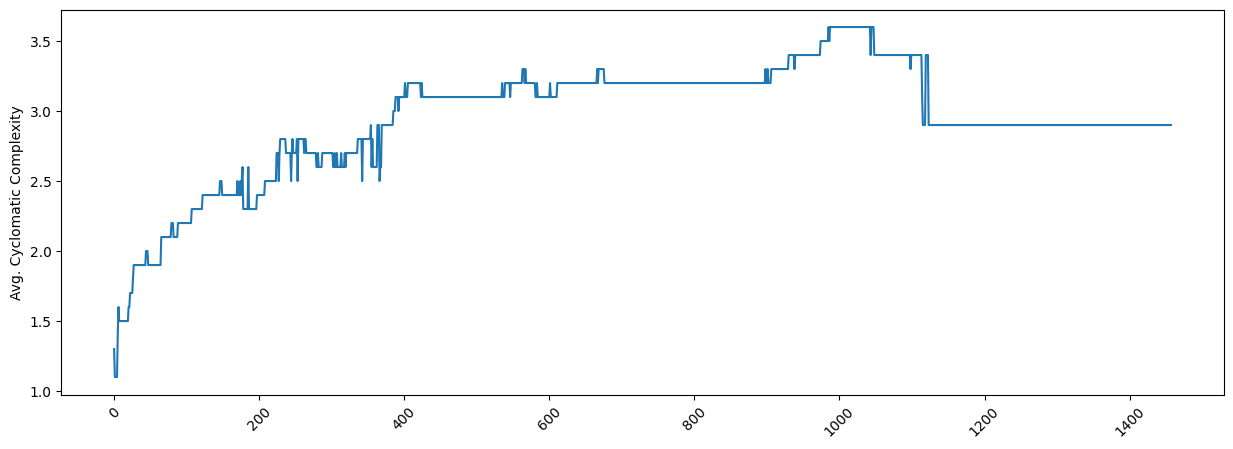

In [7]:
# Plot the graph
dataset['avg_ccn'].plot(ylabel='Avg. Cyclomatic Complexity', figsize=(15,5), rot=45)

# Save the figure
plt.savefig("question_1_plot_1" + ".jpg")

We see some significant spikes in the Avg. Cyclomatic Complexity across the year. We can further quantify this by looking at the standard deviation, which we can estimate using the std() function from pandas:

In [8]:
dataset['avg_ccn'].std()

The estimated standard deviation of ~0.0912809881831056 is not quite significant.

From our causal graph, we see that multiple variables have a direct impact on the Average cyclomatic complexity, but which of them contribute the most to the variance? To find this out, we can make use of the direct arrow strength algorithm that quantifies the causal influence of a specific arrow in the graph:

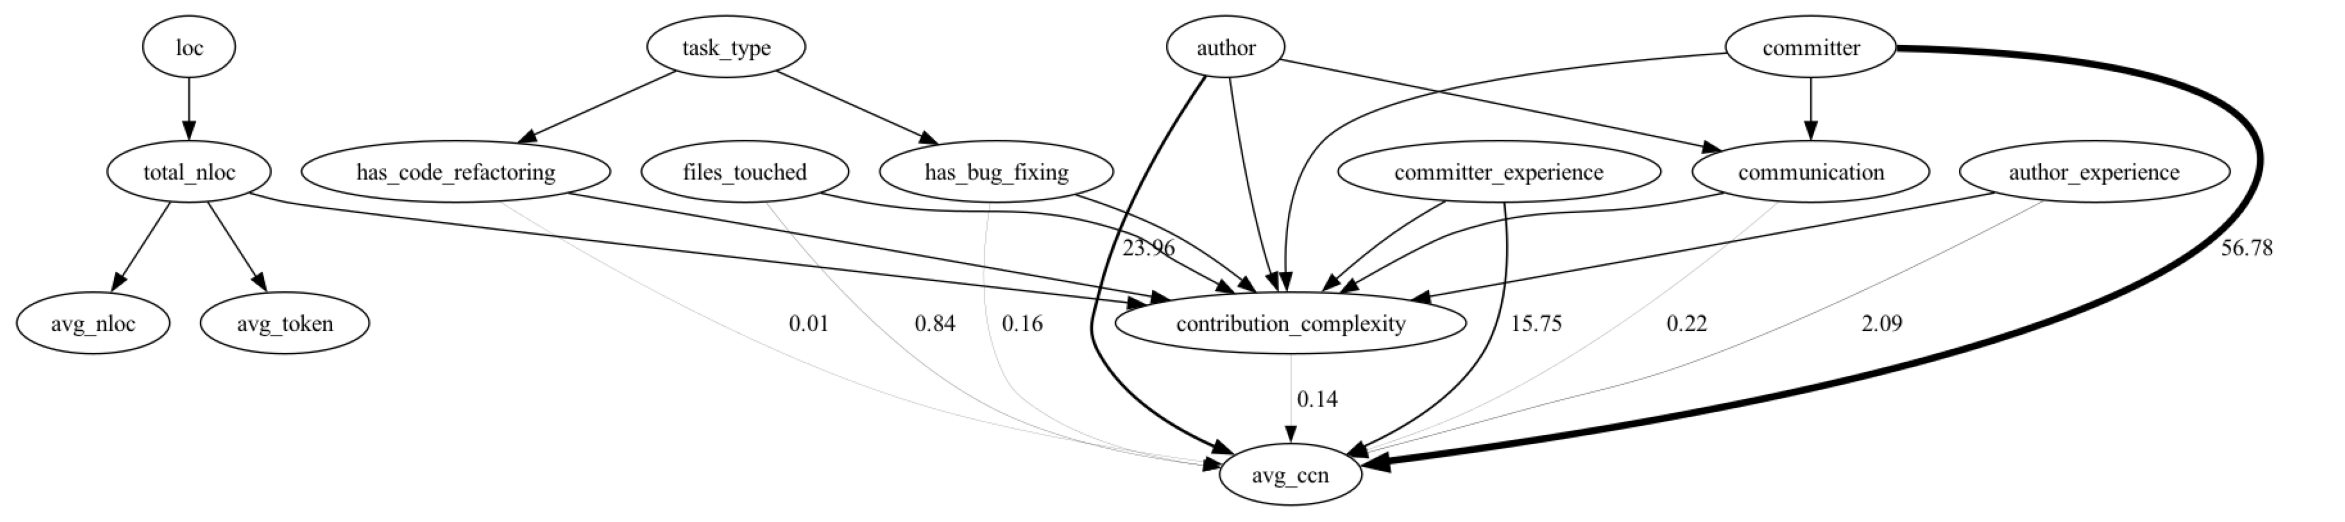

In [9]:
def convert_to_percentage(value_dictionary):
    total_absolute_sum = np.sum([abs(v) for v in value_dictionary.values()])
    return {k: abs(v) / total_absolute_sum * 100 for k, v in value_dictionary.items()}


arrow_strengths = gcm.arrow_strength(scm, target_node='avg_ccn')

gcm.util.plot(causal_graph_nx, 
              filename="causal_model_q1_gcm",
              causal_strengths=convert_to_percentage(arrow_strengths), 
              figure_size=[30, 15])


In this causal graph, we see how much each node contributes to the variance of Average cyclomatic complexity. 
While the direct influences are helpful in understanding which direct parents influence the most on the variance in Average cyclomatic complexity, this mostly confirms our prior belief. The question of which factor is now ultimately responsible for this high variance is, however, still unclear. 

Although we could recursively apply the direct arrow strength to all nodes, we would not get a correctly weighted insight into the influence of upstream nodes on the variance.

What are the important causal factors contributing to the variance in average cyclomatic complexity? To find this out, we can use the DoWhy's intrinsic causal contribution method that attributes the variance in Profit to the upstream nodes in the causal graph. For this, we first define a function to plot the values in a bar plot and then use this to display the estimated contributions to the variance as a percentages: 

Estimating Shapley Values. Average change of Shapley values in run 12 (60 evaluated permutations): -9.41816266983464%: 100%|█| 1/1 [03:33<00


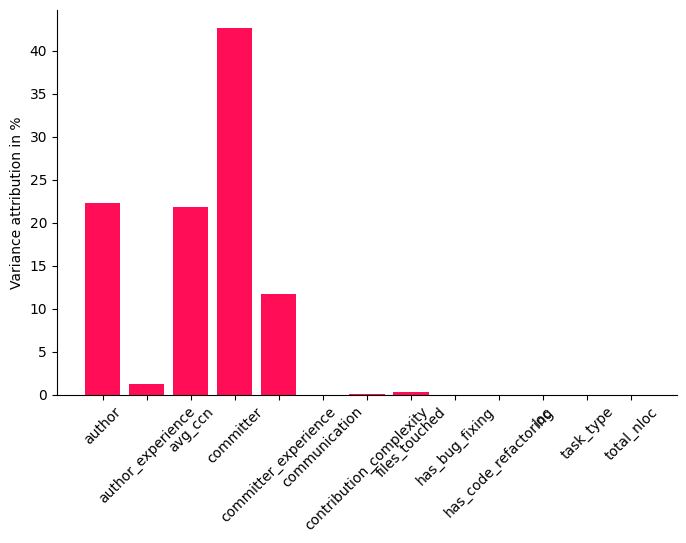

In [10]:
def bar_plot(value_dictionary, ylabel, uncertainty_attribs=None, figsize=(8, 5)):
    value_dictionary = {k: value_dictionary[k] for k in sorted(value_dictionary)}
    if uncertainty_attribs is None:
        uncertainty_attribs = {node: [value_dictionary[node], value_dictionary[node]] for node in value_dictionary}

    _, ax = plt.subplots(figsize=figsize)
    ci_plus = [uncertainty_attribs[node][1] - value_dictionary[node] for node in value_dictionary.keys()]
    ci_minus = [value_dictionary[node] - uncertainty_attribs[node][0] for node in value_dictionary.keys()]
    yerr = np.array([ci_minus, ci_plus])
    yerr[abs(yerr) < 10**-7] = 0
    plt.bar(value_dictionary.keys(), value_dictionary.values(), yerr=yerr, ecolor='#1E88E5', color='#ff0d57', width=0.8)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.show()


iccs = gcm.intrinsic_causal_influence(scm, target_node='avg_ccn', num_samples_randomization=500)

bar_plot(convert_to_percentage(iccs), ylabel='Variance attribution in %')

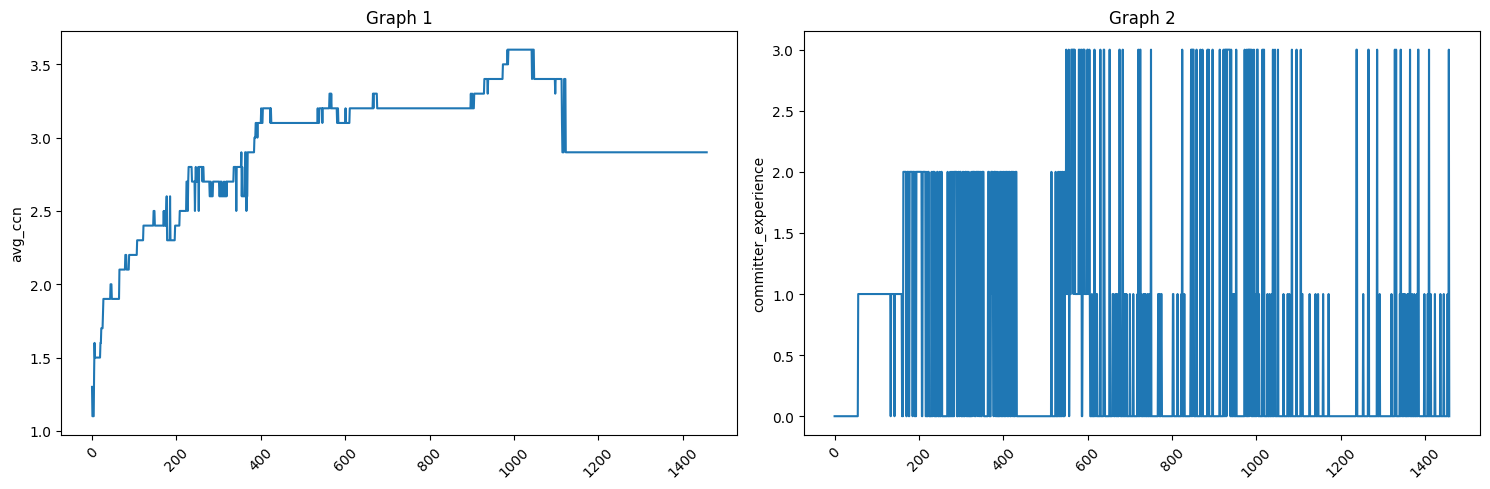

In [11]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the first graph in the left subplot
dataset['avg_ccn'].plot(ax=axs[0], ylabel='avg_ccn', rot=45)
axs[0].set_title('Graph 1')

# Plot the second graph in the right subplot
dataset['contribution_complexity'].plot(ax=axs[1], ylabel='contribution_complexity', rot=45)
axs[1].set_title('Graph 2')

# Adjust the spacing between subplots
plt.tight_layout()

# Save the figure
plt.savefig("question_1_plot_2" + ".jpg")

-- The end --